# Testing out various strategies of learning rate scheduling

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

## Loading dataset

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [3]:
x_valid, x_train = x_train_full[:5000] / 255, x_train_full[5000:] / 255
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
x_test = x_test / 255

In [4]:
mean_pixels = x_train.mean(axis = 0, keepdims = True)
std_pixels = x_train.std(axis = 0, keepdims = True)

In [5]:
x_train_scaled = (x_train - mean_pixels) / std_pixels
x_valid_scaled = (x_valid - mean_pixels) / std_pixels
x_test_scaled = (x_test - mean_pixels) / std_pixels

## Power scheduling

- We will be using the power scheduling stat for scheduling the learning rate.

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [7]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(100, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.SGD(lr = 0.01, decay = 1e-4), metrics = ['accuracy'])

In [10]:
history = model.fit(x_train_scaled, y_train, epochs = 25, validation_data = (x_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4876 - accuracy: 0.8278 - val_loss: 0.4031 - val_accuracy: 0.8606
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3805 - accuracy: 0.8655 - val_loss: 0.3722 - val_accuracy: 0.8714
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3484 - accuracy: 0.8768 - val_loss: 0.3752 - val_accuracy: 0.8676
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3280 - accuracy: 0.8838 - val_loss: 0.3529 - val_accuracy: 0.8790
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3134 - accuracy: 0.8892 - val_loss: 0.3472 - val_accuracy: 0.8764
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2996 - accuracy: 0.8942 - val_loss: 0.3470 - val_accuracy: 0.8796
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2899 - accuracy: 0.8974 - val_loss: 0.3412 - val_accuracy:

In [11]:
df_metrics = pd.DataFrame(history.history)

<AxesSubplot:>

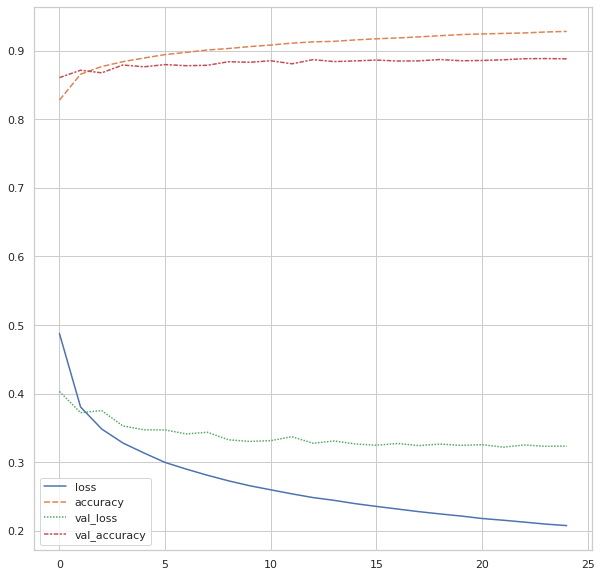

In [12]:
sns.set(style = 'whitegrid')
plt.figure(figsize = (10,10))
sns.lineplot(data = df_metrics)

In [13]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.7827 - accuracy: 0.7252: 0s - loss: 0.7827 - accuracy: 0.72


[0.782741904258728, 0.7251999974250793]

In [14]:
learning_rate = 0.01
n_epochs = 25
batch_size = 32
decay = 1e-4

In [15]:
epochs = np.arange(n_epochs)
n_batches_per_epoch = len(x_train) // batch_size

In [16]:
def lr(epoch):
    return learning_rate / (1 + (n_batches_per_epoch * epoch * decay))

<AxesSubplot:>

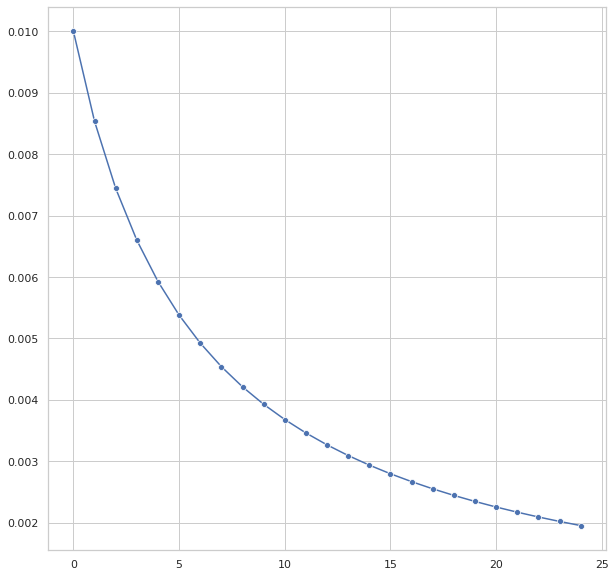

In [17]:
plt.figure(figsize = (10,10))
sns.lineplot(epochs, lr(epochs), marker = 'o')

## Exponential scheduling

- We will be writing a function which decreases the learning rate exponentially after s steps.
- We will then create a LearningRate callback and pass this function to it.

In [18]:
def lr_decay(lr0, s):
    def lr_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return lr_decay_fn

In [19]:
lr_decay_fn = lr_decay(lr0 = 0.01, s = 20)

In [20]:
keras.backend.clear_session()

In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(100, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [22]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.Nadam(lr = 0.01), metrics = ['accuracy'])

In [23]:
lr_callback = keras.callbacks.LearningRateScheduler(lr_decay_fn)

In [24]:
history = model.fit(x_train_scaled, y_train, epochs = 25, validation_data = (x_valid_scaled, y_valid), callbacks = [lr_callback])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8552 - accuracy: 0.7537 - val_loss: 0.9021 - val_accuracy: 0.7276
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6885 - accuracy: 0.7955 - val_loss: 0.6130 - val_accuracy: 0.8104
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6154 - accuracy: 0.8145 - val_loss: 0.8560 - val_accuracy: 0.7568
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5612 - accuracy: 0.8318 - val_loss: 0.5516 - val_accuracy: 0.8426
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5010 - accuracy: 0.8468 - val_loss: 0.5711 - val_accuracy: 0.8588
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4488 - accuracy: 0.8587 - val_loss: 0.5753 - val_accuracy: 0.8556
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4251 - accuracy: 0.8666 - val_loss: 0.4940 - val_accuracy:

In [25]:
df_metrics = pd.DataFrame(history.history)

In [26]:
df_metrics.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.855206,0.753745,0.902149,0.7276,0.010000
1,0.688495,0.795545,0.612958,0.8104,0.008913
2,0.615364,0.814491,0.855959,0.7568,0.007943
3,0.561187,0.831836,0.551623,0.8426,0.007079
4,0.500975,0.846764,0.571141,0.8588,0.006310


<AxesSubplot:>

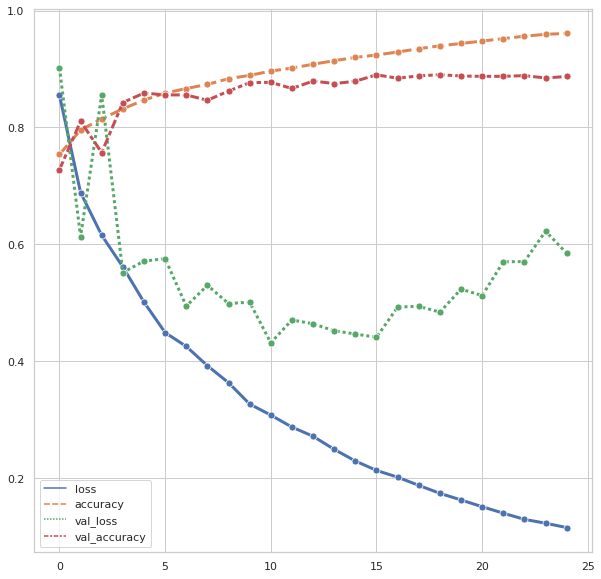

In [27]:
plt.figure(figsize = (10,10))
sns.lineplot(data = df_metrics.drop(columns = 'lr'), marker = 'o', linewidth = 3, markersize = 7)

<AxesSubplot:>

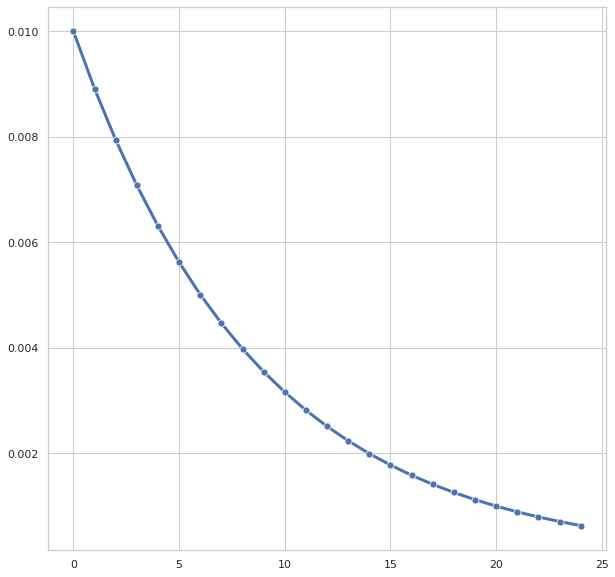

In [28]:
plt.figure(figsize = (10,10))
sns.lineplot(data = df_metrics.lr, marker = 'o', linewidth = 3, markersize = 7)

- Now we will be updating the learning rate at each step instead of each epoch.
- For this we have to write a custom callback func and then pass it as a callback while training.

In [29]:
K = keras.backend

In [30]:
class lr_decay(keras.callbacks.Callback):
    def __init__(self, s = 40000):
        super().__init__()
        self.s = s
    def on_batch_end(self, batch, logs = None):
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1 ** (1 / s))
    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [31]:
keras.backend.clear_session()

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(100, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.Nadam(lr = 0.01), metrics = ['accuracy'])

In [35]:
s = 20 * len(x_train) // 32

In [36]:
lr_callback = lr_decay(s)

In [37]:
history = model.fit(x_train_scaled, y_train, epochs = 25, validation_data = (x_valid_scaled, y_valid), callbacks = [lr_callback])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7962 - accuracy: 0.7648 - val_loss: 0.7540 - val_accuracy: 0.7466
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6448 - accuracy: 0.8014 - val_loss: 0.5130 - val_accuracy: 0.8410
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5856 - accuracy: 0.8156 - val_loss: 0.6312 - val_accuracy: 0.7860
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5252 - accuracy: 0.8358 - val_loss: 0.5216 - val_accuracy: 0.8368
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4897 - accuracy: 0.8469 - val_loss: 0.4574 - val_accuracy: 0.8646
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4259 - accuracy: 0.8645 - val_loss: 0.4638 - val_accuracy: 0.8558
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4109 - accuracy: 0.8674 - val_loss: 0.4823 - val_accuracy:

In [38]:
df_metrics = pd.DataFrame(history.history)

<AxesSubplot:>

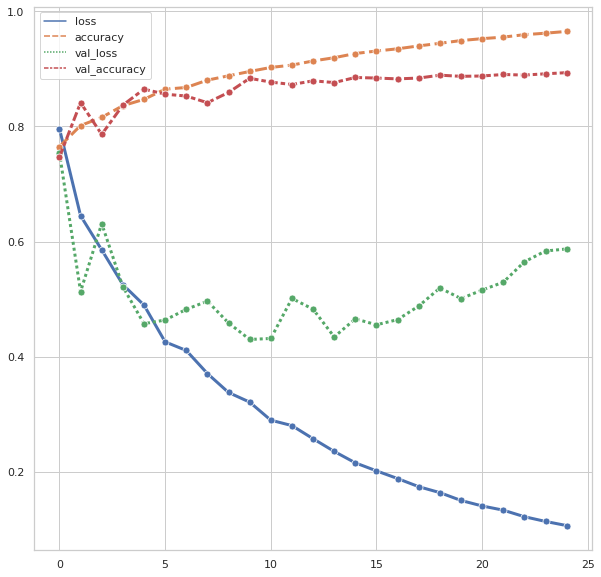

In [39]:
plt.figure(figsize = (10, 10))
sns.lineplot(data = df_metrics.drop(columns = 'lr'), linewidth = 3, marker = 'o', markersize = 7)

<AxesSubplot:>

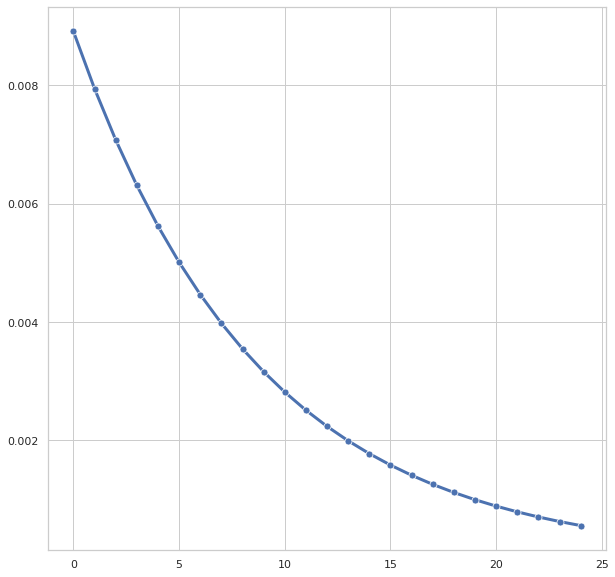

In [40]:
plt.figure(figsize = (10, 10))
sns.lineplot(data = df_metrics.lr, linewidth = 3, marker = 'o', markersize = 7)

In [41]:
n_steps = 25 * len(x_train) // 32
steps = np.arange(n_steps)

In [42]:
def lr(steps, lr0):
    return lr0 * 0.1 ** (steps / s)

<AxesSubplot:>

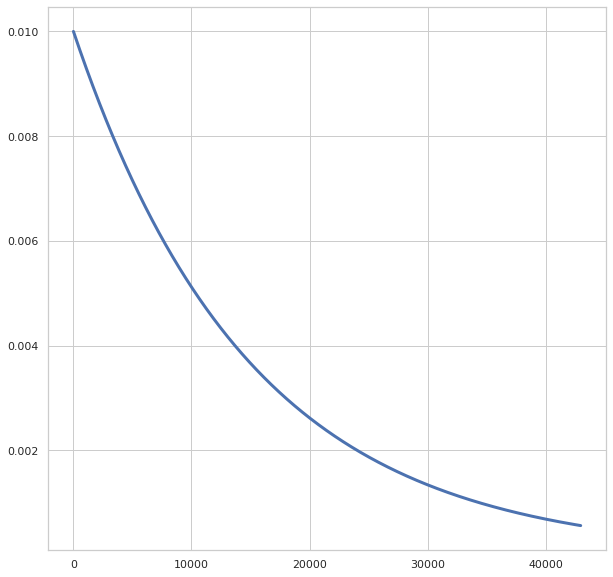

In [43]:
plt.figure(figsize = (10,10))
sns.lineplot(x = steps, y = lr(steps, 0.01), linewidth = 3)

## Piecewise constant scheduling

- In this strat, we will be setting lr as 0.01 when the no of epochs is less than 5, 0.005 when training runs between 5 and 15 epochs and 0.001 when training runs greater than 15 epochs.

In [72]:
def piecewise_scheduling(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def lr_func(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return lr_func

In [81]:
lr_piecewise_func = piecewise_scheduling([5, 15], [0.01, 0.005, 0.001])

In [77]:
keras.backend.clear_session()

In [78]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(100, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [79]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.Nadam(lr = 0.01), metrics = ['accuracy'])

In [82]:
lr_callback = keras.callbacks.LearningRateScheduler(lr_piecewise_func)

In [83]:
history = model.fit(x_train_scaled, y_train, epochs = 25, validation_data = (x_valid_scaled, y_valid), callbacks = [lr_callback])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8503 - accuracy: 0.7576 - val_loss: 1.0384 - val_accuracy: 0.7322
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8323 - accuracy: 0.7605 - val_loss: 0.9557 - val_accuracy: 0.7494
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8847 - accuracy: 0.7409 - val_loss: 1.3464 - val_accuracy: 0.6520
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8707 - accuracy: 0.7470 - val_loss: 0.8320 - val_accuracy: 0.7602
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9308 - accuracy: 0.7333 - val_loss: 0.8610 - val_accuracy: 0.7440
Epoch 6/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.6006 - accuracy: 0.8152 - val_loss: 0.6713 - val_accuracy: 0.8222
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5389 - accuracy: 0.8365 - val_loss: 0.6270 - val_accuracy:

In [84]:
df_metrics = pd.DataFrame(history.history)

In [85]:
df_metrics.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.850275,0.757618,1.038391,0.7322,0.01
1,0.832264,0.760455,0.955658,0.7494,0.01
2,0.884746,0.740873,1.346373,0.6520,0.01
3,0.870714,0.746982,0.832011,0.7602,0.01
4,0.930792,0.733273,0.861016,0.7440,0.01


<AxesSubplot:>

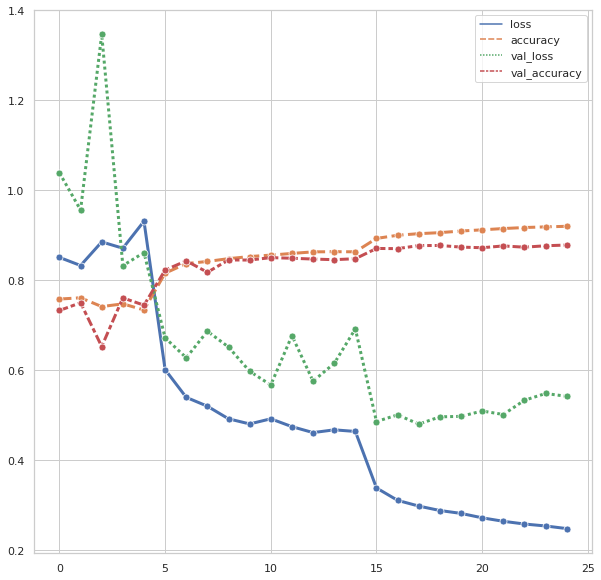

In [87]:
plt.figure(figsize = (10,10))
sns.lineplot(data = df_metrics.drop(columns = 'lr'), linewidth = 3, marker = 'o', markersize = 7)

<AxesSubplot:>

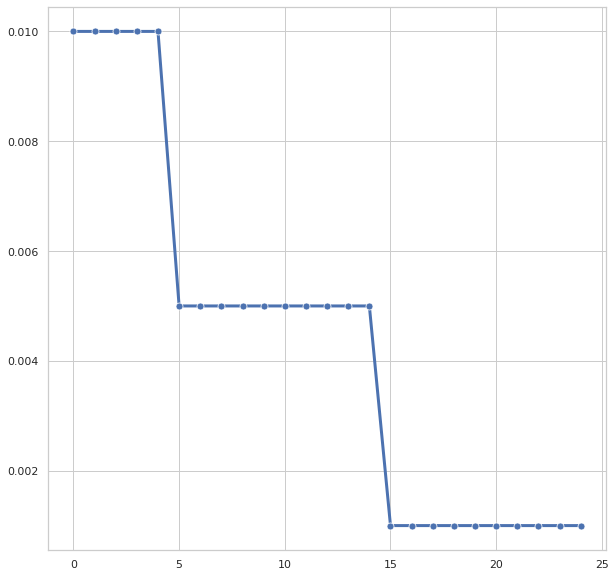

In [90]:
plt.figure(figsize = (10,10))
sns.lineplot(data = df_metrics.lr, linewidth = 3, marker = 'o', markersize = 7)

## Performance scheduling

- The learning rate here will be decreased by a factor of 0.5 when the training continues for 5 epochs without considerable decrease in the validation_error.

In [91]:
keras.backend.clear_session()

In [92]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(100, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.SGD(lr = 0.02, momentum = 0.9), metrics = ['accuracy'])

In [95]:
lr_callback = keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 5)

In [96]:
history = model.fit(x_train_scaled, y_train, epochs = 25, validation_data = (x_valid_scaled, y_valid), callbacks = [lr_callback])

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5927 - accuracy: 0.8072 - val_loss: 0.4951 - val_accuracy: 0.8468
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4967 - accuracy: 0.8401 - val_loss: 0.6257 - val_accuracy: 0.8370
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5147 - accuracy: 0.8411 - val_loss: 0.5915 - val_accuracy: 0.8478
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5189 - accuracy: 0.8464 - val_loss: 0.4631 - val_accuracy: 0.8488
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5163 - accuracy: 0.8490 - val_loss: 0.4932 - val_accuracy: 0.8508
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4991 - accuracy: 0.8543 - val_loss: 0.5297 - val_accuracy: 0.8536
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5189 - accuracy: 0.8553 - val_loss: 0.5723 - val_accuracy:

In [97]:
df_metrics = pd.DataFrame(history.history)

In [98]:
df_metrics.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.592703,0.807218,0.495054,0.8468,0.02
1,0.496694,0.840055,0.625667,0.8370,0.02
2,0.514660,0.841073,0.591542,0.8478,0.02
3,0.518939,0.846436,0.463080,0.8488,0.02
4,0.516326,0.848982,0.493230,0.8508,0.02


<AxesSubplot:>

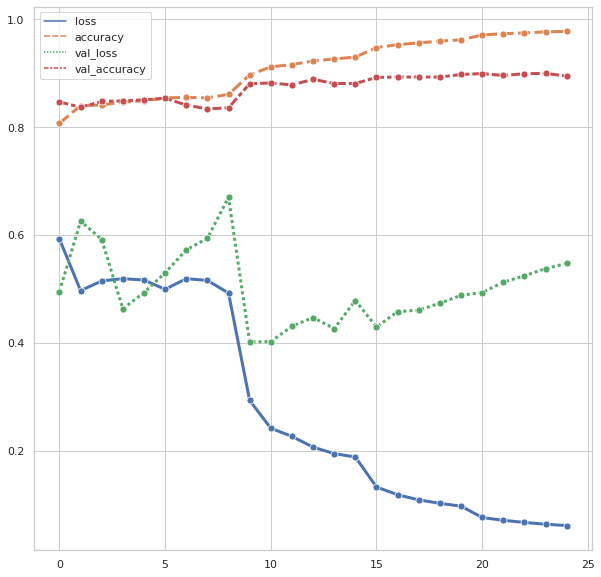

In [99]:
plt.figure(figsize = (10, 10))
sns.lineplot(data = df_metrics.drop(columns = 'lr'), linewidth = 3, marker = 'o', markersize = 7)

<AxesSubplot:label='3377ea6f-6bf7-411f-b04f-da791f951b48'>

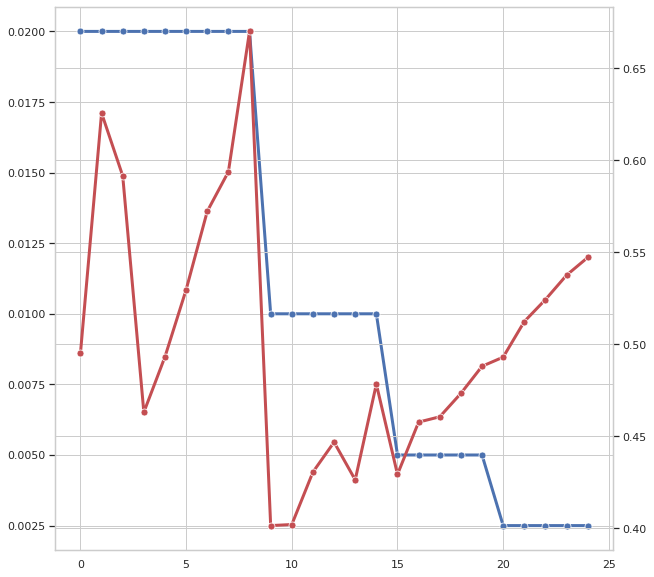

In [116]:
plt.figure(figsize = (10,10))
sns.lineplot(data = df_metrics.lr, linewidth = 3, marker = 'o', markersize = 7)
plt.gca().twinx()
sns.lineplot(data = df_metrics.val_loss, color = 'r', linewidth = 3, marker = 'o', markersize = 7)

## In-built schedulers

- These inbuilt lr schedulers are available only in tf.keras and not Keras.API

In [122]:
keras.backend.clear_session()

In [123]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(100, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [124]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [125]:
s = 20 * len(x_train) // 32
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)

In [126]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.SGD(learning_rate), metrics = ['accuracy'])

In [127]:
history = model.fit(x_train_scaled, y_train, epochs = 25, validation_data = (x_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4896 - accuracy: 0.8274 - val_loss: 0.4022 - val_accuracy: 0.8618
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3793 - accuracy: 0.8649 - val_loss: 0.3705 - val_accuracy: 0.8690
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3457 - accuracy: 0.8770 - val_loss: 0.3735 - val_accuracy: 0.8676
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3239 - accuracy: 0.8835 - val_loss: 0.3482 - val_accuracy: 0.8752
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3083 - accuracy: 0.8906 - val_loss: 0.3425 - val_accuracy: 0.8780
Epoch 6/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2942 - accuracy: 0.8947 - val_loss: 0.3417 - val_accuracy: 0.8796
Epoch 7/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2836 - accuracy: 0.8990 - val_loss: 0.3377 - val_accuracy:

In [128]:
df_metrics = pd.DataFrame(history.history)

In [129]:
df_metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,0.489606,0.827382,0.402228,0.8618
1,0.379267,0.864945,0.370524,0.8690
2,0.345742,0.876964,0.373538,0.8676
3,0.323944,0.883491,0.348194,0.8752
4,0.308269,0.890564,0.342536,0.8780


<AxesSubplot:>

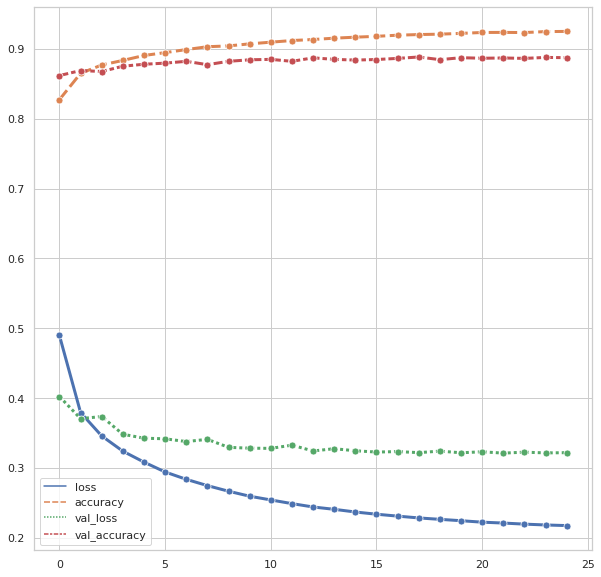

In [131]:
plt.figure(figsize = (10,10))
sns.lineplot(data = df_metrics, linewidth = 3, marker = 'o', markersize = 7)

In [132]:
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3450 - accuracy: 0.8813


[0.34496408700942993, 0.8812999725341797]

## 1cycle scheduling

- In this method, we will be first find out the max_rate used in scheduling by finding the optimal lr when loss is minimum.

In [218]:
keras.backend.clear_session()

In [219]:
K = keras.backend

In [220]:
class Exponential_decay(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs['loss'])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [221]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(100, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [222]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [223]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.SGD(lr = 1e-3), metrics = ['accuracy'])

In [224]:
iteration = 1 * len(x_train) // 128

In [225]:
factor = np.exp(np.log(10 / (10 ** -5)) / iterations)

In [226]:
K.set_value(model.optimizer.lr, 10 ** -5)

In [227]:
lr_callback = Exponential_decay(factor)

In [228]:
history = model.fit(x_train_scaled, y_train, epochs = 1, batch_size = 128, validation_data = (x_valid_scaled, y_valid), callbacks = [lr_callback])

430/430 [==============================] - 1s 3ms/step - loss: nan - accuracy: 0.3803 - val_loss: nan - val_accuracy: 0.0914


(9.999999747378752e-06,
 10.00020980834961,
 1.6583778858184814,
 2.3090018033981323)

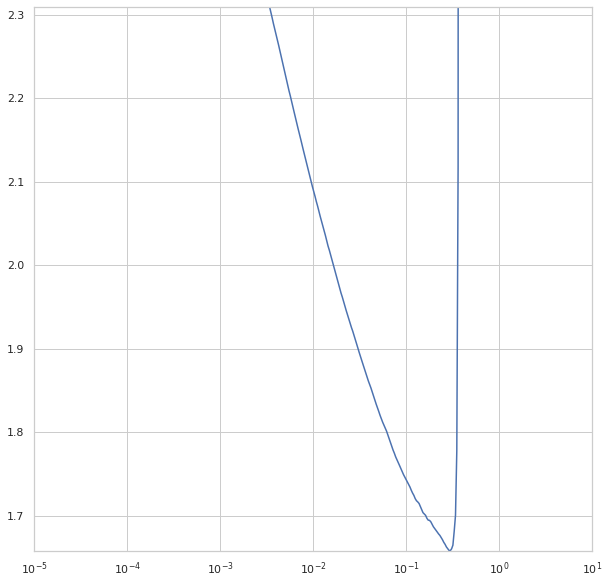

In [242]:
plt.figure(figsize = (10,10))
plt.plot(lr_callback.rates, lr_callback.losses)
plt.gca().set_xscale('log')
plt.axis([min(lr_callback.rates), max(lr_callback.rates), min(lr_callback.losses), (lr_callback.losses[0] + min(lr_callback.losses)) / 2])

- Now that we have the max_rate, we will create a custom callback func to execute the functionality of 1cycle scheduling.

In [274]:
class one_cycle_scheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate = None, last_iterations = None, last_rate = None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2 
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter_1, iter_2, rate_1, rate_2):
        return ((rate_2 - rate_1) * (self.iteration - iter_1) / (iter_2 - iter_1) + rate_1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration, self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations, self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1 
        K.set_value(self.model.optimizer.lr, rate)

In [275]:
keras.backend.clear_session()

In [276]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(100, activation = 'selu', kernel_initializer = 'lecun_normal'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [277]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [278]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.SGD(lr = 1e-3), metrics = ['accuracy'])

In [279]:
lr_callback = one_cycle_scheduler(25 * len(x_train) / 128, max_rate = 0.05)

In [280]:
history = model.fit(x_train_scaled, y_train, epochs = 25, batch_size = 128, validation_data = (x_valid_scaled, y_valid), callbacks = [lr_callback])

Epoch 1/25
430/430 [==============================] - 1s 3ms/step - loss: 0.6542 - accuracy: 0.7719 - val_loss: 0.4870 - val_accuracy: 0.8326
Epoch 2/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4591 - accuracy: 0.8387 - val_loss: 0.4289 - val_accuracy: 0.8538
Epoch 3/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4123 - accuracy: 0.8539 - val_loss: 0.4108 - val_accuracy: 0.8610
Epoch 4/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3821 - accuracy: 0.8643 - val_loss: 0.3871 - val_accuracy: 0.8676
Epoch 5/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3602 - accuracy: 0.8725 - val_loss: 0.3716 - val_accuracy: 0.8710
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3410 - accuracy: 0.8782 - val_loss: 0.3661 - val_accuracy: 0.8770
Epoch 7/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3269 - accuracy: 0.8819 - val_loss: 0.3577 - val_accuracy: 0.8764
Epoch 

In [281]:
df_metrics = pd.DataFrame(history.history)

In [282]:
df_metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,0.654199,0.771909,0.486979,0.8326
1,0.459111,0.838655,0.428906,0.8538
2,0.412332,0.853873,0.410757,0.8610
3,0.382053,0.864291,0.387149,0.8676
4,0.360192,0.872545,0.371567,0.8710


<AxesSubplot:>

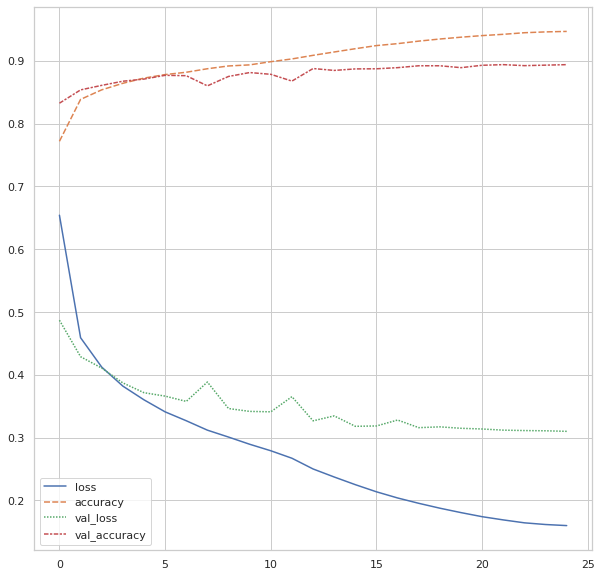

In [283]:
plt.figure(figsize = (10, 10))
sns.lineplot(data = df_metrics)

In [284]:
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3388 - accuracy: 0.8865


[0.33875682950019836, 0.8865000009536743]